In [1]:
# Global imports and settings
%matplotlib inline
from preamble import *
plt.rcParams['figure.dpi'] = 100 # Use 300 for PDF, 100 for slides
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

# Lecture 2: Linear models
Joaquin Vanschoren, Eindhoven University of Technology

## The Mathematics behind Machine Learning
* To understand machine learning algorithms, it often helps to describe them mathematically.
* To avoid confusion, let's specify a precise notation

### Basic notation
* A _scalar_ is a simple numeric value, denoted by italic letter: $x=3.24$
* A _vector_ is a 1D ordered array of _n_ scalars, denoted by bold letter: $\mathbf{x}=[3.24, 1.2]$
    * A vector can represent a _point_ in an n-dimensional space, given a _basis_.
    * $x_i$ denotes the $i$th element of a vector, thus $x_0 = 3.24$.
        * Note: some other courses use $x^{(i)}$ notation
* A _set_ is an _unordered_ collection of unique elements, denote by caligraphic capital: $\mathcal{S}=\{3.24, 1.2\}$
* A _matrix_ is a 2D array of scalars, denoted by bold capital: $\mathbf{X}=\begin{bmatrix}
3.24 & 1.2 \\
2.24 & 0.2 
\end{bmatrix}$
    * It can represent a set of points in an n-dimensional space, given a _basis_.
    * $\textbf{X}_{i}$ denotes the $i$th _row_ of the matrix
    * $\textbf{X}_{i,j}$ denotes the _element_ in the $i$th row, $j$th column, thus $\mathbf{X}_{0,1} = 2.24$
* The _standard basis_ for a Euclidean space is the set of unit vectors
    * Data can also be represented in a non-standard basis (e.g. polynomials) if useful 

* A _tensor_ is an _k_-dimensional array of data, denoted by an italic capital: $T$
    * _k_ is also called the _order_, _degree_, or _rank_
    * $T_{i,j,k,...}$ denotes the element or sub-tensor in the corresponding position
    * A set of color images can be represented by:
        * a 4D tensor (sample x height x weight x color channel)
        * a 2D tensor (sample x flattened vector of pixel values)
    
<img src="../images/08_images.png" alt="ml" style="width: 40%;"/>

### Basic operations
* Sums and products are denoted by capital Sigma and capital Pi:
$$\sum_{i=0}^{n} = x_0 + x_1 + ... + x_p \quad \prod_{i=0}^{n} = x_0 \cdot x_1 \cdot ... \cdot x_p$$
* Operations on vectors are _element-wise_: e.g. $\mathbf{x}+\mathbf{z} = [x_0+z_0,x_1+z_1, ... , x_p+z_p]$
* Dot product $\mathbf{w}\mathbf{x} = \mathbf{w} \cdot \mathbf{x} = \sum_{i=0}^{p} w_i \cdot x_i = w_0 \cdot x_0 + w_1 \cdot x_1 + ... + w_p \cdot x_p$
* Matrix product $\mathbf{W}\mathbf{x} = \begin{bmatrix}
\mathbf{w_0} \cdot \mathbf{x} \\
... \\
\mathbf{w_p} \cdot \mathbf{x} \end{bmatrix}$
* A function $f(x) = y$ relates an input element $x$ to an output $y$
    * It has a _local minimum_ at $x=c$ if $f(x) \geq f(c)$ in interval $(c-\epsilon, c+\epsilon)$
    * It has a _global minimum_ at $x=c$ if $f(x) \geq f(c)$ for any value for $x$
* A vector function consumes an input and produces a vector: $\mathbf{f}(\mathbf{x}) = \mathbf{y}$
* $\underset{x\in X}{\operatorname{max}}f(x)$ returns the highest value f(x) for any x
* $\underset{c\in C}{\operatorname{argmax}}f(x)$ returns the element c that maximizes f(c)

### Gradients
* A _derivative_ $f'$ of a function $f$ describes how fast $f$ grows or decreases
* The process of finding a derivative is called differentiation
    * Derivatives for basic functions are known
    * For non-basic functions we use the _chain rule_: $F(x) = f(g(x)) \rightarrow F'(x)=f'(g(x))g'(x)$
* A function is _differentiable_ if it has a derivate in any point of it's domain
    * It's _continuously differentiable_ if $f'$ is itself a function
    * It's _smooth_ if $f', f'', f''', ...$ all exist
* A _gradient_ $\nabla f$ is the derivate of a function in multiple dimensions
    * It is a vector of _partial derivatives_: $\nabla f = \left[ \frac{\partial f}{\partial x_0}, \frac{\partial f}{\partial x_1},... \right]$
    * E.g. $f=2x_0+3x_1^{2}-\sin(x_2) \rightarrow \nabla f= [2, 6x_1, -cos(x_2)]$

### Probabilities
* A random variable $X$ can be continuous or discrete
* A probability distribution of a discrete variable is the list of probabilities for each possible value
    * Also called the _probability mass function_ (_pmf_)
    * The _expectation_ (or _mean_) $\mathbb{E}[X] = \mu_X = \sum_{i=1}^k[x_i \cdot Pr(X=x_i)]$
    * The standard deviation $\sigma = \sqrt{\mathbb{E}[(X-\mu)^2]}$ and variance $var(X) = \sigma^2$
* A probability distribution $f_X$ of a continuous variable $X$ is described by a _probability density function_ (_pdf_)
    * The _expectation_ is given by $\mathbb{E}[X] = \int_{\mathbb{R}} x f_X(x) dx$
   
<img src="../images/02_pdf.png" alt="ml" style="width: 50%;"/>

# Linear models
Linear models make a prediction using a linear function of the input features. Can be very powerful for or datasets with many features. 

If you have more features than training data points, any target y can be perfectly modeled (on the training set) as a linear function.

## Linear models for regression
Prediction formula for input features x. $w_i$ and b are the _model parameters_ that need to be learned.  

$$\hat{y} = \mathbf{w}\mathbf{x} + b = \sum_{i=0}^{p} w_i \cdot x_i + b = w_0 \cdot x_0 + w_1 \cdot x_1 + ... + w_p \cdot x_p + b $$

There are many different algorithms, differing in how w and b are learned from the training data.

w[0]: 0.393906  b: -0.031804


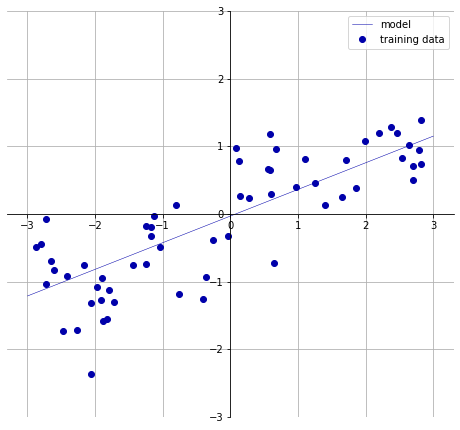

In [2]:
mglearn.plots.plot_linear_regression_wave()

### Linear Regression aka Ordinary Least Squares
* Finds the parameters w and b that minimize the _mean squared error_ between predictions (red) and the true regression targets (blue), y, on the training set. 
    * MSE: Sum of the squared differences (residuals) between the predictions $\hat{y_i}$ and the true values $y_i$.
$$\mathcal{L}_{MSE} = \sum_{n=0}^{N} (y_n-\hat{y_n})^2 = \sum_{n=0}^{N} (y_n-(\mathbf{w}\mathbf{x_n} + b))^2$$ 
* Convex optimization problem with unique closed-form solution (if you have more data points than model parameters w)
* It has no hyperparameters, thus model complexity cannot be controlled.

<img src="../images/02_least_squares.png" alt="ml" style="width: 550px;"/>

Linear regression can be found in `sklearn.linear_model`. We'll evaluate it on the Boston Housing dataset.

``` python
lr = LinearRegression().fit(X_train, y_train)
```

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X, y = mglearn.datasets.load_extended_boston()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
lr = LinearRegression().fit(X_train, y_train)

In [4]:
print("Weights (coefficients): {}".format(lr.coef_[0:40]))
print("Bias (intercept): {}".format(lr.intercept_))

Weights (coefficients): [ -412.711   -52.243  -131.899   -12.004   -15.511    28.716    54.704
   -49.535    26.582    37.062   -11.828   -18.058   -19.525    12.203
  2980.781  1500.843   114.187   -16.97     40.961   -24.264    57.616
  1278.121 -2239.869   222.825    -2.182    42.996   -13.398   -19.389
    -2.575   -81.013     9.66      4.914    -0.812    -7.647    33.784
   -11.446    68.508   -17.375    42.813     1.14 ]
Bias (intercept): 30.93456367364464


In [5]:
print("Training set score (R^2): {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score (R^2): {:.2f}".format(lr.score(X_test, y_test)))

Training set score (R^2): 0.95
Test set score (R^2): 0.61


### Ridge regression
* Same formula as linear regression
* Adds a penalty term to the least squares sum:

$$\mathcal{L}_{Ridge} = \sum_{n=0}^{N} (y_n-(\mathbf{w}\mathbf{x_n} + b))^2 + \alpha \sum_{i=0}^{p} w_i^2$$ 

* Requires that the coefficients (w) are close to zero.
    * Each feature should have as little effect on the outcome as possible 
* Regularization: explicitly restrict a model to avoid overfitting. 
* Type of L2 regularization: prefers many small weights
    * L1 regularization prefers sparsity: many weights to be 0, others large

`Ridge` can also be found in `sklearn.linear_model`.  
`ridge = Ridge().fit(X_train, y_train)`

In [6]:
from sklearn.linear_model import Ridge

ridge = Ridge().fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test, y_test)))

Training set score: 0.89
Test set score: 0.75


Test set score is higher and training set score lower: less overfitting!

The strength of the regularization can be controlled with the `alpha` parameter. Default is 1.0.
* Increasing alpha forces coefficients to move more toward zero (more regularization)
* Decreasing alpha allows the coefficients to be less restricted (less regularization)

We can plot the weight values for differents levels of regularization. Move the slider to increase/decrease regularization. Increasing regularization decreases the values of the coefficients, but never to 0.

In [24]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from sklearn.linear_model import Ridge

X, y = mglearn.datasets.load_extended_boston()
X_B_train, X_B_test, y_B_train, y_B_test = train_test_split(X, y, random_state=0)

@interact
def plot_ridge(alpha=(0,10.0,0.05)):
    r = Ridge(alpha=alpha).fit(X_B_train, y_B_train)
    fig, ax = plt.subplots(figsize=(8,2))
    ax.plot(r.coef_, 'o')
    ax.set_title("alpha {}, score {:.2f} (training score {:.2f})".format(alpha, r.score(X_B_test, y_B_test), r.score(X_B_train, y_B_train)))
    ax.set_xlabel("Coefficient index")
    ax.set_ylabel("Coefficient magnitude")
    ax.hlines(0, 0, len(r.coef_))
    ax.set_ylim(-25, 25)
    ax.set_xlim(0, 50);

interactive(children=(FloatSlider(value=5.0, description='alpha', max=10.0, step=0.05), Output()), _dom_classe…

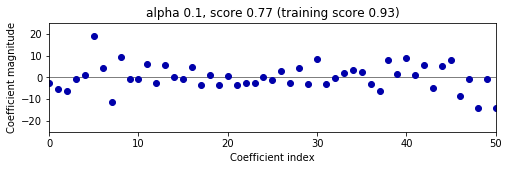

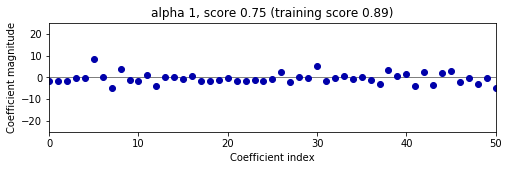

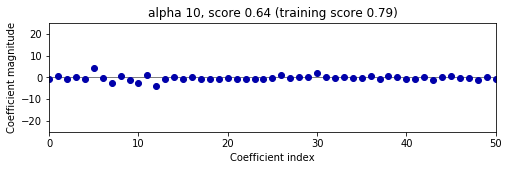

In [25]:
for alpha in [0.1, 1, 10]:
    plot_ridge(alpha)

Another way to understand the influence of regularization is to fix a value of alpha but vary the amount of training data available. With enough training data, regularization becomes less important: ridge and linear regression will have the same performance.

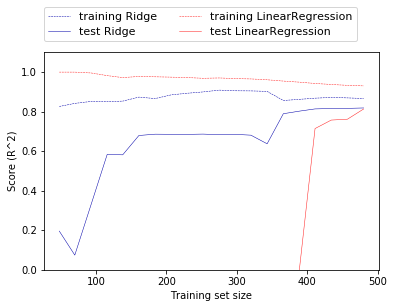

In [9]:
mglearn.plots.plot_ridge_n_samples()

### Lasso (Least Absolute Shrinkage and Selection Operator)
* Another form of regularization
* Adds a penalty term to the least squares sum:
$$\mathcal{L}_{Lasso} = \sum_{n=0}^{N} (y_n-(\mathbf{w}\mathbf{x_n} + b))^2 + \alpha \sum_{i=0}^{p} |w_i|$$ 
* Prefers coefficients to be exactly zero (L1 regularization).
* Some features are entirely ignored by the model: automatic feature selection.
* Same parameter `alpha` to control the strength of regularization. 
* Convex, but no longer strictly convex (and NOT differentiable). Weights can be optimized using (for instance) _coordinate descent_
* New parameter `max_iter`: the maximum number of coordinate descent iterations
    * Should be higher for small values of `alpha`

### Gradient Descent
* Start with a random set of p weights values $\mathbf{w}^0$
* Compute the derivative of the objective function $\mathcal{L}$ (e.g. $\mathcal{L_{Ridge}}$) and use it to find the slope (in p dimensions)
* Update all weights slightly (step size $\gamma$) in the direction of the downhill slope. For step s:
$$\mathbf{w}^{s+1} = \mathbf{w}^s-\gamma\nabla \mathcal{L}(\mathbf{w}^s)$$

* Repeat for `max_iter` iterations
* Visualization in 1 dimension (for 1 weight):
<img src="../images/01_gradient_descent.jpg" alt="ml" style="width: 500px;"/>

### Gradient Descent
In two dimensions:
<img src="../images/01_gradient_descent_2D.png" alt="ml" style="width: 700px;"/>


### Gradient Descent
* Intuition: walking downhill using only the slope you "feel" nearby

<img src="../images/01_gradient_descent_hill.png" alt="ml" style="width: 600px;"/>

### Coordinate descent
- Variation of gradient descent, also applicable for non-differentiable loss functions
- Faster iterations, may converge more slowly
- In every iteration, optimizes a single coordinate $w_i$, using a coordinate selection rule (e.g. round robin)
    - If $\mathcal{L}$ is differentiable, the update rule is based on the partial derivative: $w_i^{s+1} = w_i^{s} − \gamma \frac{\partial \mathcal{L}}{\partial w_i}$
    - If $\mathcal{L}$ is not differentiable but convex, the [_subgradient_](https://www.cs.cmu.edu/~ggordon/10725-F12/slides/06-sg-method.pdf) can be computed. 
- For Lasso, the [resulting update rule]((https://xavierbourretsicotte.github.io/lasso_derivation.html)) includes the _soft thresholding operator S_: $w_i^{s+1} \cong S(f(w_i^{s}),\alpha)$
    - _S_ sets $w_i$'s to 0 when they are sufficiently small ('sufficiently' is defined by $\alpha$)

<img src="../images/02_cd.png" alt="ml" style="width: 400px;"/>

We can again analyse what happens to the weigths. Increasing regularization under L1 leads to many coefficients becoming exactly 0.

In [26]:
from sklearn.linear_model import Lasso

@interact
def plot_lasso(alpha=(0,0.5,0.005)):
    r = Lasso(alpha=alpha).fit(X_B_train, y_B_train)
    fig, ax = plt.subplots(figsize=(8,2))
    ax.plot(r.coef_, 'o')
    ax.set_title("alpha {}, score {:.2f} (training score {:.2f})".format(alpha, r.score(X_B_test, y_B_test), r.score(X_B_train, y_B_train)))
    ax.set_xlabel("Coefficient index")
    ax.set_ylabel("Coefficient magnitude")
    ax.hlines(0, 0, len(r.coef_))
    ax.set_ylim(-25, 25);
    ax.set_xlim(0, 50);

interactive(children=(FloatSlider(value=0.25, description='alpha', max=0.5, step=0.005), Output()), _dom_class…

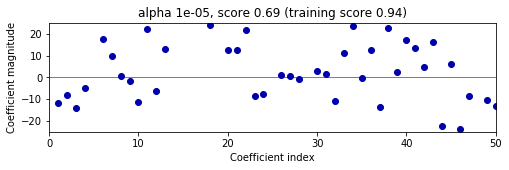

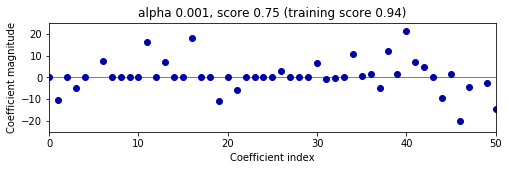

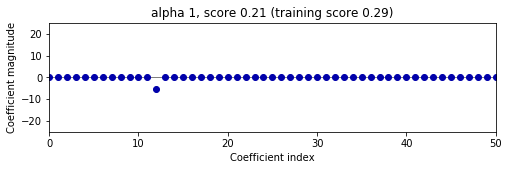

In [27]:
for alpha in [0.00001, 0.001, 1]:
    plot_lasso(alpha)

## Interpreting L1 and L2 loss
- Red ellipses are the contours of the least squares error function
- In blue are the constraints imposed by the L1 (left) and L2 (right) loss
- For L1, the likelihood of hitting the objective with the corners is higher
    - Weights of other coefficients are 0, hence sparse representations
- For L2, it could intersect at any point, hence non-zero weights
- From _Elements of Statistical Learning_:

![L1 and L2 loss](../images/02_lossfunctions.png)

#### Linear models for Classification
Aims to find a (hyper)plane that separates the examples of each class.  
For binary classification (2 classes), we aim to fit the following function: 

$\hat{y} = w_0 * x_0 + w_1 * x_1 + ... + w_p * x_p + b > 0$  
    
When $\hat{y}<0$, predict class -1, otherwise predict class +1

There are many algorithms for learning linear classification models, differing in:

* Loss function: evaluate how well the linear model fits the training data
* Regularization techniques

Most common techniques:

* Logistic regression: 
    * `sklearn.linear_model.LogisticRegression`
* Linear Support Vector Machine: 
    * `sklearn.svm.LinearSVC`


##### Logistic regression
The logistic model uses the _logistic_ (or _sigmoid_) function to estimate the probability that a given sample belongs to class 1:
$$ z = f(x) = w_0 * x_0 + w_1 * x_1 + ... + w_p * x_p $$
$$ \hat{y} = Pr[1|x_1,...,x_k] = g(z) = \frac{1}{1+e^{-z}} $$
![LogisticRegression image](../images/01_logistic.png)

[Source](https://florianhartl.com/logistic-regression-geometric-intuition.html)

On 2-dimensional data: 
![LogisticRegression image](../images/02_logistic2d.png)

* The logistic function is chosen because it maps values (-Inf,Inf) to a probability [0,1]
* We add a new dimension for the dependent variable $\text{y}$ and fit the logistic function g(z) so that it separates the samples as good as possible. The positive (blue) points are mapped to 1 and the negative (red) points to 0.
* After fitting, the logistic function provides the probability that a new point is positive. If we need a binary prediction, we can threshold at 0.5.
* There are different ways to find the optimal parameters w that fit the training data best

###### Fitting (solving): cross-entropy
* We define the difference (error) between the actual probabilies (frequencies) $p_i$ and the predicted probabilities $q_i$ is the cross-entropy $H(p,q)$:
$$ H(p,q) = - \sum_{i} p_i log(q_i) $$
* Note: Instead of minimizing cross-entropy $H(p,q)$, you can maximize _log-likelihood_ $-H(p,q)$, and hence this is also called _maximum likelihood_ estimation
* In binary classification, $i=0,1$ and $p_1=y$, $p_0=1-y$, $q_1=\hat{y}$, $q_0=1-\hat{y}$
* And thus:
$$ H(p,q) = - y log(\hat{y}) - (1-y) log(1-\hat{y})$$

###### Fitting (solving): cross-entropy loss
* Loss function: the average of all cross-entropies in the sample (of $N$ data points):
$$\mathcal{L_{log}}(\mathbf{w}) = \sum_{n=1}^{N} H(p_n,q_n) = \sum_{n=1}^{N} \big[ - y_n log(\hat{y_n}) - (1-y_n) log(1-\hat{y_n}) \big]$$
with $$\hat{y_n} = \frac{1}{1+e^{\mathbf{w} \cdot \mathbf{x}}}$$
* This is called _logistic loss_, _log loss_ or _cross-entropy loss_
* We can (and should always) add a regularization term, either L1 or L2, e.g. for L2:
$$\mathcal{L_{log}}'(\mathbf{w}) = \mathcal{L_{log}}(\mathbf{w}) + \alpha \sum_{i} w_i^2 $$
    - Note: sklearn uses $C$ instead of $\alpha$, and it is the inverse (smaller values, more regularization)

###### Fitting (solving): optimization methods
* There are different ways to optimize cross-entropy loss.
* Gradient descent
    - The logistic function is differentiable, so we can use (stochastic) gradient descent
    - Stochastic Average Gradient descent (SAG): only updates gradient in one direction at each step
* Coordinate descent (default, called `liblinear` in sklearn)
    - Faster, may converge more slowly, may more easily get stuck in local minima
* Newton-Rhapson (or Newton Conjugate Gradient):
    - Finds optima by computing second derivatives (more expensive)
    - Works well if solution space is (near) convex
    - Also known as _iterative re-weighted least squares_
* Quasi-Newton methods
    - Approximate, faster to compute
    - E.g. Limited-memory Broyden–Fletcher–Goldfarb–Shanno (`lbfgs`)

##### Linear Support Vector Machine (intuition)
Find hyperplanes (dashed lines) maximizing the _margin_ between the classes  
<img src="../images/01_svm.png" alt="ml" style="width: 600px;"/>

###### Optimization and prediction
* Prediction is identical to (weighted) kNN:
    * Points closest to the red support vector are classified red, others blue
    * A support vector can also have a weight (see later)
* The objective function penalizes every point predicted to be on the `wrong` side of its hyperplane
    * This is called _hinge loss_
* This results in a convex optimization problem solved using the _Langrange Multipliers_ method
    * Can also be solved using gradient descent
* This will all be discussed at length later

Comparison

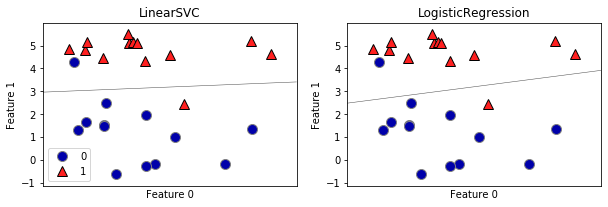

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

X, y = mglearn.datasets.make_forge()

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

for model, ax in zip([LinearSVC(), LogisticRegression()], axes):
    clf = model.fit(X, y)
    mglearn.plots.plot_2d_separator(clf, X, fill=False, eps=0.5,
                                    ax=ax, alpha=.7)
    mglearn.discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    ax.set_title("{}".format(clf.__class__.__name__))
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
axes[0].legend();

Both methods can be regularized:
* L2 regularization by default, L1 also possible
* _C_ parameter: inverse of strength of regularization
    * higher _C_: less regularization
    * penalty for misclassifying points while keeping $w_i$ close to 0

High _C_ values (less regularization): fewer misclassifications but smaller margins.

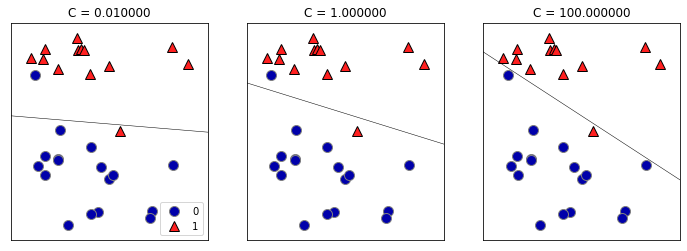

In [13]:
mglearn.plots.plot_linear_svc_regularization()

Model selection: Logistic regression  
`logreg = LogisticRegression(C=1).fit(X_train, y_train)`

Adjust the slider to see the effect of C and L1/L2 regularization

In [28]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
X_C_train, X_C_test, y_C_train, y_C_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=42)

@interact
def plot_logreg(C=(0.01,100.0,0.1), penalty=['l1','l2']):
    r = LogisticRegression(C=C, penalty=penalty).fit(X_C_train, y_C_train)
    fig, ax = plt.subplots(figsize=(8,2))
    ax.plot(r.coef_.T, 'o')
    ax.set_title("C {}, score {:.2f} (training score {:.2f})".format(C, r.score(X_C_test, y_C_test), r.score(X_C_train, y_C_train)))
    ax.set_xlabel("Coefficient index")
    ax.set_ylabel("Coefficient magnitude")
    ax.hlines(0, 0, len(r.coef_))
    ax.set_ylim(-15, 15)
    ax.set_xlim(0, 30);

interactive(children=(FloatSlider(value=49.910000000000004, description='C', min=0.01), Dropdown(description='…

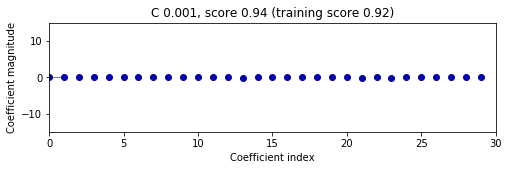

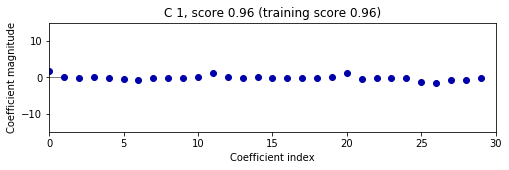

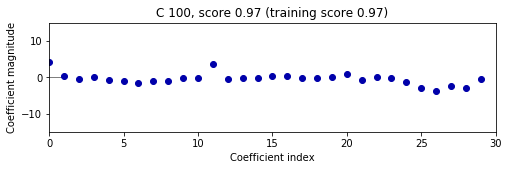

In [29]:
for C in [0.001, 1, 100]:
    plot_logreg(C, 'l2')

## Uncertainty estimates from classifiers
* Classifiers can often provide uncertainty estimates of predictions.  
* Remember that linear models actually return a numeric value.
    - When $\hat{y}<0$, predict class -1, otherwise predict class +1
    $$\hat{y} = w_0 * x_0 + w_1 * x_1 + ... + w_p * x_p + b $$  
* In practice, you are often interested in how certain a classifier is about each class prediction (e.g. cancer treatments).  


Scikit-learn offers 2 functions. Often, both are available for every learner, but not always.

- decision_function: returns floating point value for each sample
- predict_proba: return probability for each class

### The Decision Function
In the binary classification case, the return value of decision_function is of shape (n_samples,), and it returns one floating-point number for each sample. This value encodes how strongly the model believes a data point to belong to the “positive” class.

- Positive values indicate a preference for the "positive" class
- Negative values indicate a preference for the "negative" (other) class

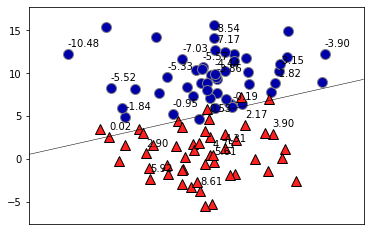

In [16]:
# create and split a synthetic dataset
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_blobs
X, y = make_blobs(centers=2, cluster_std=2.5, random_state=8)

# we rename the classes "blue" and "red"
y_named = np.array(["blue", "red"])[y]

# we can call train test split with arbitrary many arrays
# all will be split in a consistent manner
X_train, X_test, y_train_named, y_test_named, y_train, y_test = \
    train_test_split(X, y_named, y, random_state=0)

# build the logistic regression model
lr = LogisticRegression()
lr.fit(X_train, y_train_named)

# get the decision function
dec = lr.decision_function(X_test)

mglearn.plots.plot_2d_separator(lr, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y);

for i, v in enumerate(dec):
    plt.annotate("{:.2f}".format(v), (X_test[i,0],X_test[i,1]),
                 textcoords="offset points", xytext=(0,7))

* The range of decision_function can be arbitrary, and depends on the data and the model parameters. This makes it sometimes hard to interpret.
* We can visualize the decision function as follows, with the actual decision boundary left and the values of the decision boudaries color-coded on the right.  
* Note how the test examples are labeled depending on the decision function.

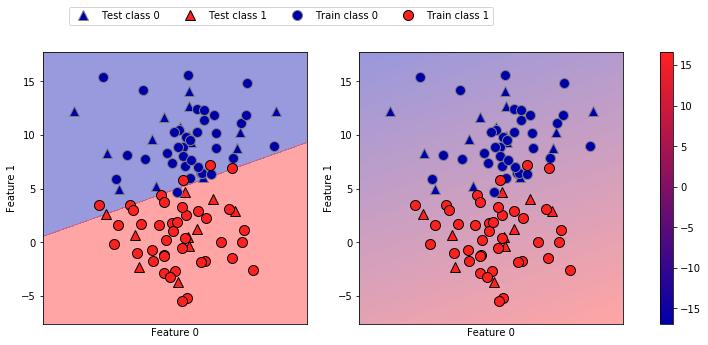

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
    
mglearn.tools.plot_2d_separator(lr, X, ax=axes[0], alpha=.4,
                                fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(lr, X, ax=axes[1],
                                            alpha=.4, cm=mglearn.ReBl)

for ax in axes:
    # plot training and test points
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test,
                             markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train,
                             markers='o', ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
cbar = plt.colorbar(scores_image, ax=axes.tolist())
cbar.set_alpha(1)
cbar.draw_all()
axes[0].legend(["Test class 0", "Test class 1", "Train class 0",
                "Train class 1"], ncol=4, loc=(.1, 1.1));  

### Predicting probabilities
The output of predict_proba is a _probability_ for each class, with one column per class. They sum up to 1.

In [18]:
print("Shape of probabilities: {}".format(lr.predict_proba(X_test).shape))
# show the first few entries of predict_proba
print("Predicted probabilities:\n{}".format(
      lr.predict_proba(X_test[:6])))

Shape of probabilities: (25, 2)
Predicted probabilities:
[[0.371 0.629]
 [0.013 0.987]
 [0.003 0.997]
 [0.052 0.948]
 [0.009 0.991]
 [0.999 0.001]]


We can visualize them again. Note that the gradient looks different now.

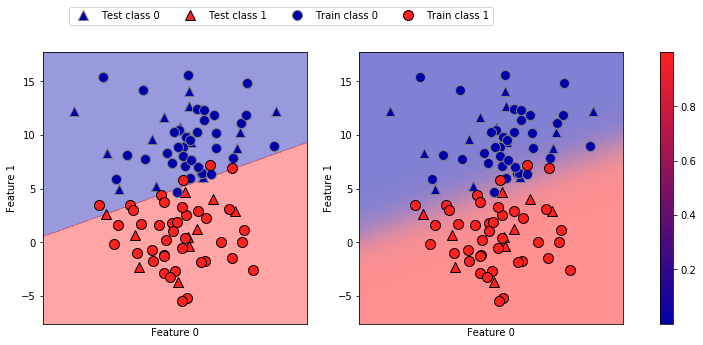

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
    
mglearn.tools.plot_2d_separator(
    lr, X, ax=axes[0], alpha=.4, fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(
    lr, X, ax=axes[1], alpha=.5, cm=mglearn.ReBl, function='predict_proba')

for ax in axes:
    # plot training and test points
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test,
                             markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train,
                             markers='o', ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
# don't want a transparent colorbar
cbar = plt.colorbar(scores_image, ax=axes.tolist())
cbar.set_alpha(1)
cbar.draw_all()
axes[0].legend(["Test class 0", "Test class 1", "Train class 0",
                "Train class 1"], ncol=4, loc=(.1, 1.1));

### Interpreting probabilities

- The class with the highest probability is predicted.
- How well the uncertainty actually reflects uncertainty in the data depends on the model and the parameters. 
    - An overfitted model tends to make more certain predictions, even if they might be wrong. 
    - A model with less complexity usually has more uncertainty in its predictions. 
- A model is called _calibrated_ if the reported uncertainty actually matches how correct it is
    — A prediction made with 70% certainty would be correct 70% of the time.
    - LogisticRegression returns well calibrated predictions by default as it directly optimizes log-loss
    - Linear SVM are not well calibrated. They are _biased_ towards points close to the decision boundary.
- [Calibration techniques](http://scikit-learn.org/stable/modules/calibration.html) can calibrate models in post-processing.

Compare logistic regression and linear SVM

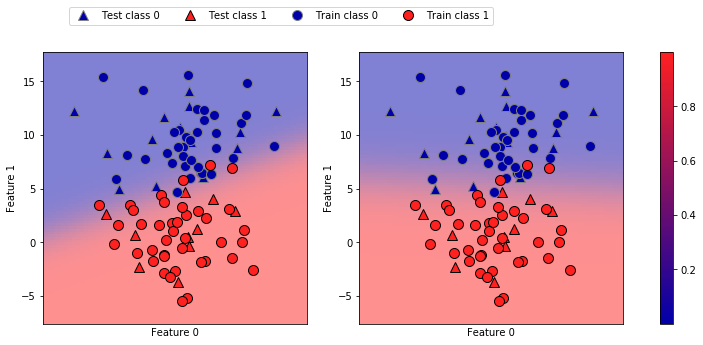

In [20]:
from sklearn.svm import SVC
svc = SVC(kernel="linear",C=0.1,probability=True).fit(X_train, y_train_named)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

lr_image = mglearn.tools.plot_2d_scores(
    lr, X, ax=axes[0], alpha=.5, cm=mglearn.ReBl, function='predict_proba')
svc_image = mglearn.tools.plot_2d_scores(
    svc, X, ax=axes[1], alpha=.5, cm=mglearn.ReBl, function='predict_proba')

for ax in axes:
    # plot training and test points
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test,
                             markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train,
                             markers='o', ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
# don't want a transparent colorbar
cbar = plt.colorbar(lr_image, ax=axes.tolist())
cbar.set_alpha(1)
cbar.draw_all()
axes[0].legend(["Test class 0", "Test class 1", "Train class 0",
                "Train class 1"], ncol=4, loc=(.1, 1.1));

### Linear Models for multiclass classification
Common technique: one-vs.-rest approach:

* A binary model is learned for each class vs. all other classes
* Creates as many binary models as there are classes
* Every binary classifiers makes a prediction, the one with the highest score (>0) wins

Build binary linear models:

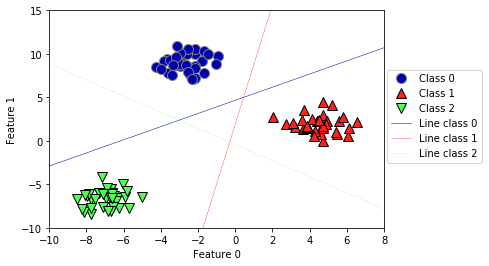

In [21]:
from sklearn.datasets import make_blobs

X, y = make_blobs(random_state=42)
linear_svm = LinearSVC().fit(X, y)

mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
line = np.linspace(-15, 15)
for coef, intercept, color in zip(linear_svm.coef_, linear_svm.intercept_,
                                  mglearn.cm3.colors):
    plt.plot(line, -(line * coef[0] + intercept) / coef[1], c=color)
plt.ylim(-10, 15)
plt.xlim(-10, 8)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend(['Class 0', 'Class 1', 'Class 2', 'Line class 0', 'Line class 1',
            'Line class 2'], loc=(1.01, 0.3));

Actual predictions (decision boundaries):

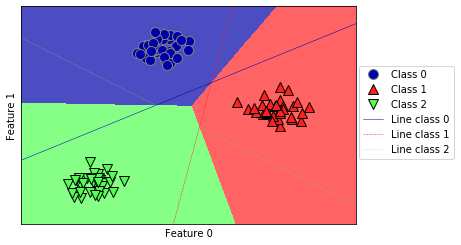

In [22]:
mglearn.plots.plot_2d_classification(linear_svm, X, fill=True, alpha=.7)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
line = np.linspace(-15, 15)
for coef, intercept, color in zip(linear_svm.coef_, linear_svm.intercept_,
                                  mglearn.cm3.colors):
    plt.plot(line, -(line * coef[0] + intercept) / coef[1], c=color)
plt.legend(['Class 0', 'Class 1', 'Class 2', 'Line class 0', 'Line class 1',
            'Line class 2'], loc=(1.01, 0.3))
plt.xlabel("Feature 0")
plt.ylabel("Feature 1");

### Uncertainty in multi-class classification

- `decision_function` and `predict_proba` also work in the multiclass setting
- always have shape (n_samples, n_classes)
- Example on the Iris dataset, which has 3 classes:

In [23]:
from sklearn.datasets import load_iris

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state=42)

lr2 = LogisticRegression()
lr2 = lr2.fit(X_train, y_train)

print("Decision function:\n{}".format(lr2.decision_function(X_test)[:6, :]))
# show the first few entries of predict_proba
print("Predicted probabilities:\n{}".format(lr2.predict_proba(X_test)[:6]))

Decision function:
[[ -4.748   0.113  -1.084]
 [  3.683  -1.914 -10.976]
 [-10.126   0.901   4.262]
 [ -4.505  -0.498  -0.92 ]
 [ -4.887   0.265  -1.512]
 [  3.354  -1.622 -10.167]]
Predicted probabilities:
[[0.011 0.669 0.32 ]
 [0.884 0.116 0.   ]
 [0.    0.419 0.581]
 [0.016 0.561 0.423]
 [0.01  0.75  0.24 ]
 [0.854 0.146 0.   ]]


### Algorithm overview

| Name | Representation | Loss function | Optimization | Regularization |
|---|---|---|---|---|
| Least squares    | Linear function | MSE | Convex optimization (CFS) | None |
| Ridge regression | Linear function | MSE + L2 | Convex optimization (CFS) | L2 loss (alpha)  |
| Lasso regression | Linear function | MSE + L1 | Coordinate descent   | L1 loss (alpha)  |
| Logistic regression | Linear function | Log Loss | Gradient/coordinate descent  | L1 or L2 (C) |
| Linear SVM | Weighted data points | Hinge loss | Constrained optimization  | L1 or L2 (C) |
| kNN | All data points | N/A | N/A  | n_neighbors |

* CFS: Closed-form solution

### Linear models: Strengths, weaknesses and parameters
Regularization parameters:

* Regression: alpha (higher values, simpler models)
    * Ridge (L2), Lasso (L1), LinearRegression (None)
* Classification: C (smaller values, simpler models)
    * LogisticRegression or SVC (both have L1/L2 option)

L1 vs L2:

* L2 is default
* Use L1 if you assume that few features are important
    * Or, if model interpretability is important

Other options:

* ElasticNet regression: allows L1 vs L2 trade-off
* SGDClassifier/SGDRegressor: optimize $w_i$,$b$ with stochastic gradient descent (more scalable)

Consider linear models when:

* number of features is large compared to the number of samples
    * other algorithms perform better in low-dimensional spaces 
* very large datasets (fast to train and predict)
    * other algorithms become (too) slow

## Summary

- Linear models
    - Go-to as a first algorithm to try, good for very large datasets, good for very high-dimensional data.
- Regularization is important. Choose between Ridge (L2) or Lasso (L1)
- Each algorithm has its own objective function, and each function can be optimized by certain techniques.
- Regression:
    - Ridge: L2 loss + least squares
    - Lasso: L1 loss + gradient descent
- Classification:
    - Logistic regression: Cross-entropy + gradient descent (or others)
    - SVM: Hinge loss + Langrange multipliers
- Classifiers return a certainty estimate. The actual prediction can be _calibrated_ towards a specific goal. 
- Multi-class classification can be done using a one-vs-all approach